# Proyecto 2

**Tema:** Predicción de enfermedades Cardíacas


|     Nombres      |      Apellidos       |     Login     |  Codigo   |
| :--------------: | :------------------: | :-----------: | :-------: |
|     Santiago     | Gonzalez Montealegre | s.gonzalez35  | 202012274 |
| Juliana Carolina |  Cardenas Barragan   | jc.cardenasb1 | 202011683 |


## Medidas de Desempeño - Original

## K-Fold Cross Validation

## Librerías Requeridas

In [1]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

## Carga de Datos

In [28]:
df = pd.read_csv("../../../Data/Transformed/Otro_Grupo.csv")
df.rename(columns={'cardiac': 'heartdis'}, inplace=True)
df['sex'] = df['sex'].astype(int)
df['cp'] = df['cp'].astype(int)
df['fbs'] = df['fbs'].astype(int)
df['restecg'] = df['restecg'].astype(int)
df['exang'] = df['exang'].astype(int)
df['slope'] = df['slope'].astype(int)
df['ca'] = df['ca'].astype(int)
df['thal'] = df['thal'].astype(int)

In [29]:
df

,age_group,sex,cp,trestbps_group,chol_group,fbs,restecg,exang,slope,ca,thal,heartdis
0,Mayor,1,1,presion arterial nivel 2,alto,1,2,0,3,0,6,False
1,Mayor,1,4,presion arterial nivel 2,muy alto,0,2,1,2,3,3,True
2,Mayor,1,4,elevada,alto,0,2,1,2,2,7,True
3,Joven,1,3,presion arterial nivel 1,muy alto,0,0,0,3,0,3,False
4,Joven,0,2,presion arterial nivel 1,alto,0,2,0,1,0,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...
292,Mayor,0,4,presion arterial nivel 2,muy alto,0,0,1,2,0,7,True
293,Joven,1,1,normal,muy alto,0,0,0,2,0,7,True
294,Mayor,1,4,presion arterial nivel 2,normal,1,0,0,2,2,7,True
295,Mayor,1,4,presion arterial nivel 1,normal,0,0,1,2,1,7,True


## K-Fold

In [8]:
variables = [column for column in list(df.columns) if column != 'heartdis']

X = df[variables].values
y = df['heartdis'].values

kf = KFold(n_splits=4, shuffle=True, random_state=1)

splits = list(kf.split(X))

## Test

In [9]:
def inferenceEvidence(evidence, model):
    
    infer = VariableElimination(model)

    prob = infer.query(variables=['heartdis'], evidence=evidence)
    
    return prob.values.tolist()

In [10]:
def getEvidence(nodes, row):
    
    evidence = {}
    for node in nodes:
        if node != 'heartdis':
            evidence[node] = (row[node])
    
    return evidence

In [11]:
def getClassification(probs):
    cero = probs[0]
    one = probs[1]
    if cero >= one:
        result = 0
    else:
        result = 1
        
    return result

In [12]:
def getMetrics(df_test):
    
    # confussion_matrix = [[None, None],[None, None]]
    
    metrics = {'TN': None, 'FP': None, 'FN': None, 'TP': None}
    
    df_needed = df_test[['heartdis', 'test']]
    
    true_negatives_df = df_needed[(df_needed['heartdis'] == df_needed['test']) & (df_needed['test'] == 0)]
    true_negatives = true_negatives_df['test'].count()
    
    false_positives_df = df_needed[(df_needed['heartdis'] != df_needed['test']) & (df_needed['test'] == 1)]
    false_positives = false_positives_df['test'].count()
    
    false_negatives_df = df_needed[(df_needed['heartdis'] != df_needed['test']) & (df_needed['test'] == 0)]
    false_negatives = false_negatives_df['test'].count()
    
    
    true_positives_df = df_needed[(df_needed['heartdis'] == df_needed['test']) & (df_needed['test'] == 1)]
    true_positives = true_positives_df['test'].count()
    
    metrics['TN'] = true_negatives
    metrics['FP'] = false_positives
    metrics['FN'] = false_negatives
    metrics['TP'] = true_positives
    
    return metrics

In [41]:
def trainModel(df_train):
    model = BayesianNetwork(
        [
            ('age_group', 'ca'),
            ('age_group', 'heartdis'),
            ('age_group', 'chol_group'),
            ('age_group', 'fbs'),
            ('age_group', 'trestbps_group'),
            ('heartdis', 'ca'),
            ('heartdis', 'cp'),
            ('heartdis', 'exang'),
            ('heartdis', 'restecg'),
            ('heartdis', 'slope'),
            ('heartdis', 'thal'),
            ('cp', 'exang'),
            ('fbs', 'heartdis'),
            ('sex', 'heartdis'),
            ('sex', 'thal')
        ]
    )

    model.fit (
        data=df_train,
        estimator=MaximumLikelihoodEstimator,    
    )
    model.check_model()
    
    return model

In [42]:
# Iterate over the K-Fold

kfold_metrics = []
for train_index, test_index in splits:
    
    # Get the Train and Test set
    
    X_train = X[train_index]
    y_train = y[train_index]
    
    X_test = X[test_index]
    y_test = y[test_index]
    
    df_train = pd.DataFrame(X_train, columns=variables)
    df_train['heartdis'] = y_train

    df_test = pd.DataFrame(X_test, columns=variables)
    df_test['heartdis'] = y_test
    
    # Train the Model
    
    model = trainModel(df_train)
    
    nodes = model.nodes    
    
    # Test the model
    
    test = []
    for i in range(0, len(df_test)):
        row = df_test.iloc[i]
        evidence = getEvidence(nodes=nodes, row=row)
        probs = inferenceEvidence(evidence, model)
        classification = getClassification(probs)
        test.append(classification)

    df_test['test'] = test
    
    metrics = getMetrics(df_test)
    
    kfold_metrics.append(metrics)

df_performance = pd.DataFrame(kfold_metrics)

df_performance['accuracy'] = (df_performance['TN'] + df_performance['TP']) / (df_performance['TN'] + df_performance['FP'] + df_performance['FN'] + df_performance['TP'])
df_performance['precision'] = (df_performance['TP']) / (df_performance['FP'] + df_performance['TP'])
df_performance['recall'] = (df_performance['TP']) / (df_performance['FN'] + df_performance['TP'])
df_performance['f1_score'] = 2 * (df_performance['precision'] * df_performance['recall']) / (df_performance['precision'] + df_performance['recall'])
df_performance['specificity'] = (df_performance['TN']) / (df_performance['TN'] + df_performance['FP'])

c:\Users\SGM\AppData\Local\Programs\Python\Python310\lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:478: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()


## Evaluation Metrics

In [43]:
df_performance

,TN,FP,FN,TP,accuracy,precision,recall,f1_score,specificity
0,34,7,8,26,0.800000,0.787879,0.764706,0.776119,0.829268
1,34,7,8,25,0.797297,0.781250,0.757576,0.769231,0.829268
2,33,4,6,31,0.864865,0.885714,0.837838,0.861111,0.891892
3,35,6,7,26,0.824324,0.812500,0.787879,0.800000,0.853659


In [44]:
accuracy = df_performance['accuracy'].mean()
precision = df_performance['precision'].mean()
recall = df_performance['recall'].mean()
f1_score = df_performance['f1_score'].mean()
specificity = df_performance['specificity'].mean()

print(f'accuracy: \t {round(accuracy, 2)}')
print(f'precision: \t {round(precision, 2)}')
print(f'recall: \t {round(recall, 2)}')
print(f'f1_score: \t {round(f1_score, 2)}')
print(f'specificity: \t {round(specificity, 2)}')

accuracy: 	 0.82
precision: 	 0.82
recall: 	 0.79
f1_score: 	 0.8
specificity: 	 0.85


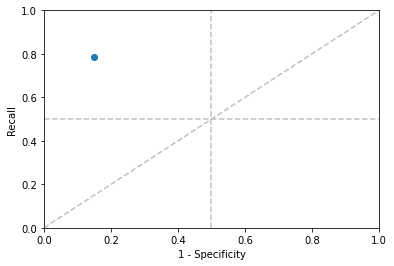

In [45]:
# Create plot
fig, ax =plt.subplots()

# Ax limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Lines for guide
ax.axvline(x=0.5, color='silver', linestyle='--')
ax.axhline(y=0.5, color='silver', linestyle='--')
x = [0, 1]
y = [0, 1]
ax.plot(x, y, color='silver', linestyle='--')

ax.scatter(1-specificity, recall)

plt.xlabel("1 - Specificity")
plt.ylabel("Recall")
plt.show()

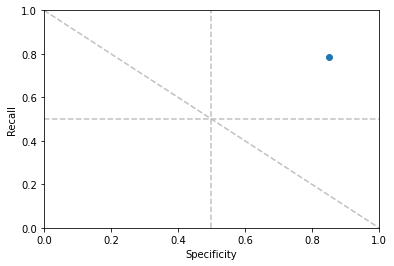

In [46]:
# Create plot
fig, ax =plt.subplots()

# Ax limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Lines for guide
ax.axvline(x=0.5, color='silver', linestyle='--')
ax.axhline(y=0.5, color='silver', linestyle='--')
x = [0, 1]
y = [1, 0]
ax.plot(x, y, color='silver', linestyle='--')

ax.scatter(specificity, recall)

plt.xlabel("Specificity")
plt.ylabel("Recall")
plt.show()